# Use continuous wavelet transform to perform time-frequency analysis of the near-bore hole events

In [78]:
# Import modules
from os.path import join
from obspy import read, UTCDateTime
from numpy import amax, abs, linspace, arange, log10
from pandas import DataFrame, Timedelta, Timestamp
from matplotlib.pyplot import subplots
import matplotlib.patches as patches
from pywt import wavelist, scale2frequency, cwt

from utils_basic import ROOTDIR, VELOCITY_UNIT, DELTA
from utils_cc import get_timewin_from_template_name
from utils_preproc import read_and_process_windowed_waveforms
from utils_snuffler import read_normal_markers
from utils_spec import get_data_spectrum, get_data_psd, get_filter_response

In [79]:
# Inputs
## Time windows and stations
stations = ["B04", "B03", "B02"]
evname = "BeatB16-22-01-27"

begin_read = -0.5
end_read = 1.5

## Parameters for the wavelet transform
bandwidth = 30.0
centerfreq = 1.0
wavelet = f"cmor{bandwidth}-{centerfreq}"
#wavelet = "mexh"

scales = linspace(1, 100, 401)

## Filtering paramgters
freqmin_filt = 10.0
freqmax_filt = 450.0

## Plotting parameters
linewidth_wf = 1.0
linewidth_psd = 1.5

freqmin_plot = 10.0
freqmax_plot = 200.0

timemin_plot = -0.1
timemax_plot = 0.25

loc_cbar = [0.92, 0.4, 0.015, 0.15]

## Scale factors for plotting the waveforms and PSDs
scale_wf = 1.05
scale_psd = 3.0

psdmin = 1e-2

ydim_ax = 5

freqs_ref = [80.0, 100.0, 115.0]

linewidth_wf = 2.0
linewidth_freq = 1.5

fontsize_big = 12
fontsize_middle = 10

In [80]:
# Read the snuffler pick file
timewin = get_timewin_from_template_name(evname)
pickdf = read_normal_markers(join(ROOTDIR, timewin, f"xpicks_{evname}.dat"))

In [81]:
# Read and process the data
stream = read_and_process_windowed_waveforms(pickdf, freqmin_filt, freqmax_filt, begin=begin_read, end=end_read, stations=stations)

B04
B03
B02


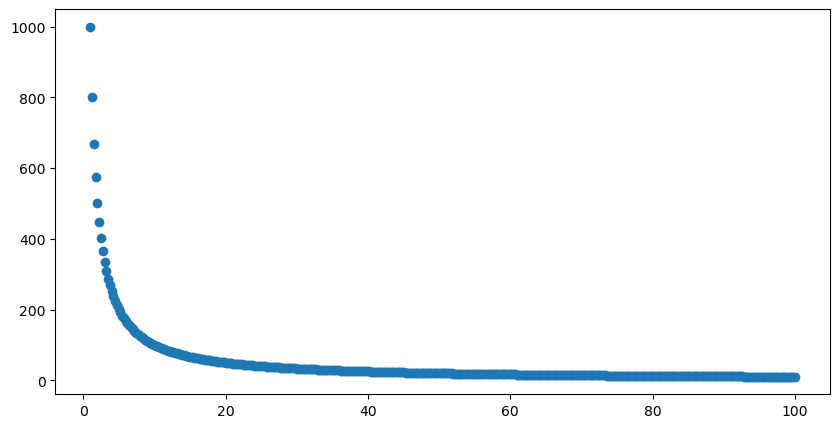

In [82]:
# Visualize the frequencies for the wavelet transform
samprat = stream[0].stats.sampling_rate
freqs = scale2frequency(wavelet, scales) * samprat
fig, ax = subplots(1, figsize=(10, 5))
ax.scatter(scales, freqs)

In [83]:
# Compute the continuous wavelet transform
cwtdict = {}

for station in stations:
    # Get the traces
    trace_z = stream.select(station=station, component="Z")[0]
    trace_1 = stream.select(station=station, component="1")[0]
    trace_2 = stream.select(station=station, component="2")[0]

    data_z = trace_z.data
    data_1 = trace_1.data
    data_2 = trace_2.data

    samprat = trace_z.stats.sampling_rate
    sampint = trace_z.stats.delta
    timeax = trace_z.times()+begin_read


    ## Compute the CWT
    cwtmatr_z, _ = cwt(data_z, scales, wavelet, sampint)
    cwtmatr_1, _ = cwt(data_1, scales, wavelet, sampint)
    cwtmatr_2, _ = cwt(data_2, scales, wavelet, sampint)

    cwtmax = max(amax(abs(cwtmatr_z)), amax(abs(cwtmatr_1)), amax(abs(cwtmatr_2)))
    cwtmatr_z = log10(abs(cwtmatr_z) / cwtmax)
    cwtmatr_1 = log10(abs(cwtmatr_1) / cwtmax)
    cwtmatr_2 = log10(abs(cwtmatr_2) / cwtmax)

    cwtdict[(station, "Z")] = cwtmatr_z
    cwtdict[(station, "1")] = cwtmatr_1
    cwtdict[(station, "2")] = cwtmatr_2

Figure saved to /Volumes/OmanData/geophones_no_prefilt/data/2020-01-16-22-00-00/cwt_BeatB16-22-01-27.png


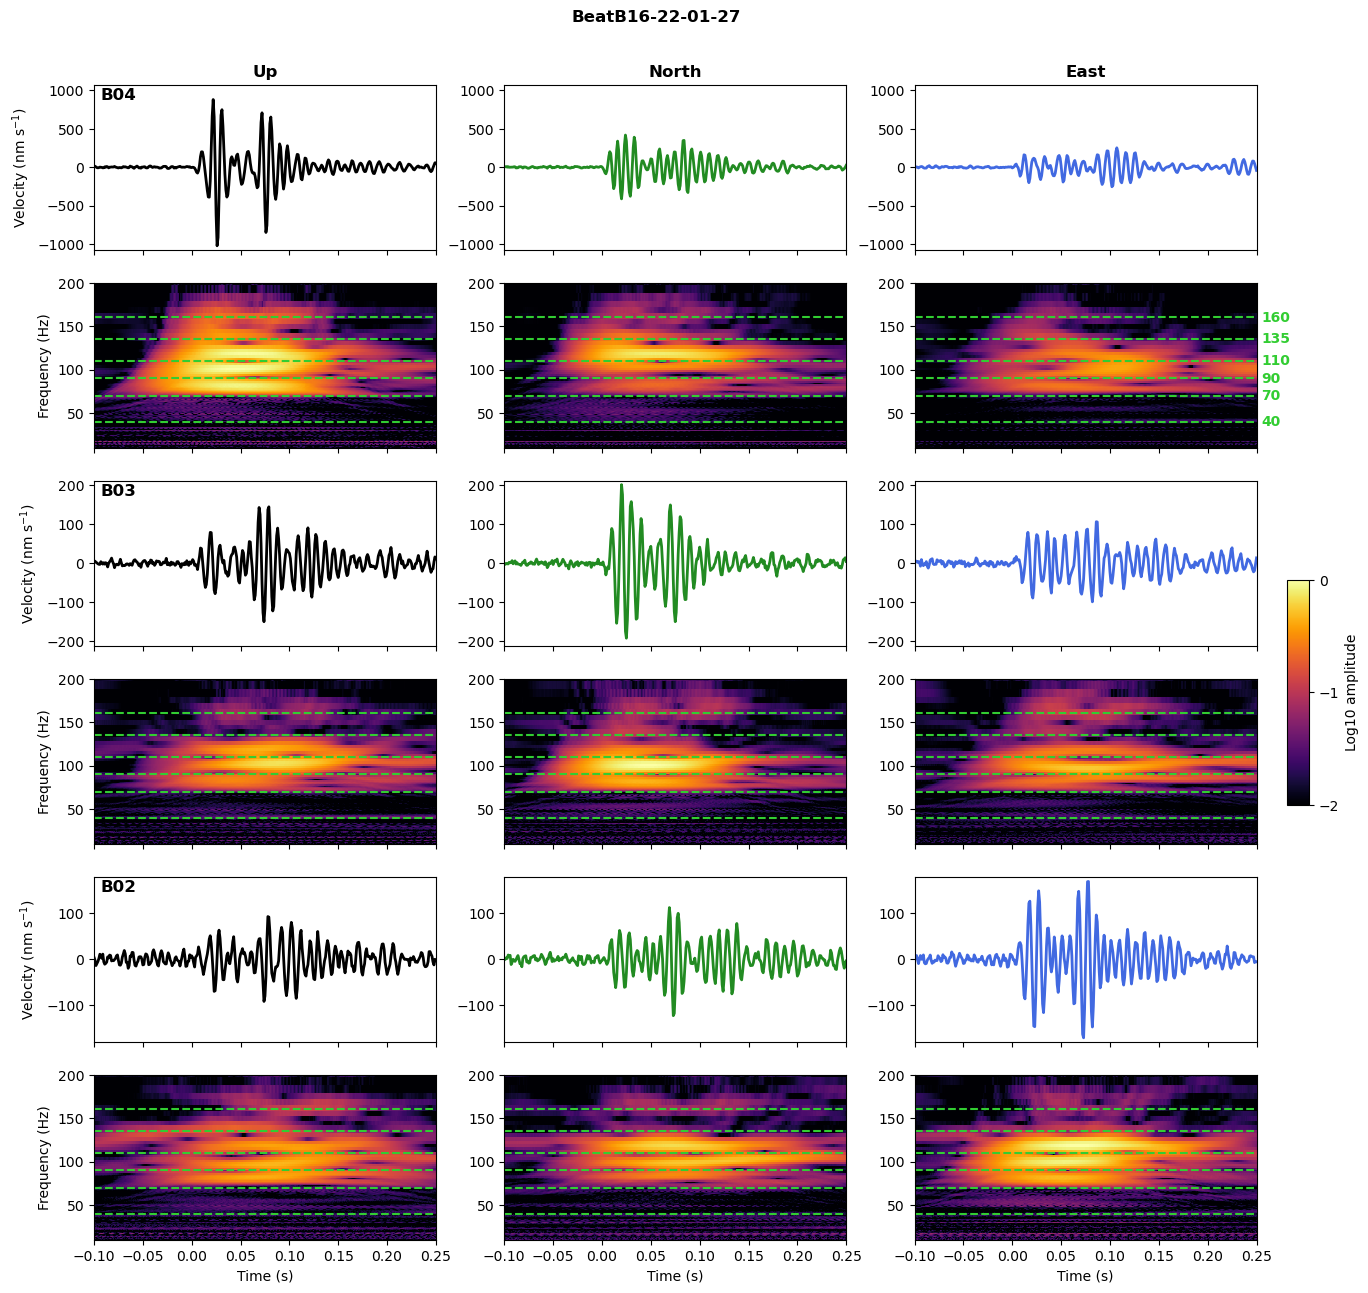

In [84]:
## Visualize the waveforms and the CWT
numsta = len(stations)

fig, axes = subplots(2 * numsta, 3, figsize=(ydim_ax * numsta, 15), sharex=True)

## Plot the waveforms
for i, station in enumerate(stations):
    data_z = stream.select(station=station, component="Z")[0].data
    data_1 = stream.select(station=station, component="1")[0].data
    data_2 = stream.select(station=station, component="2")[0].data

    wfmax = max([amax(abs(data_z)), amax(abs(data_1)), amax(abs(data_2))])

    ax = axes[2 * i, 0]
    ax.plot(timeax, data_z, linewidth=linewidth_wf, color='black')
    ax.set_xlim(timemin_plot, timemax_plot)
    ax.set_ylim(-scale_wf*wfmax, scale_wf*wfmax)
    ax.text(0.02, 0.98, f"{station}", transform=ax.transAxes, fontsize=fontsize_big, fontweight='bold', ha='left', va='top')
    ax.set_ylabel(f"Velocity ({VELOCITY_UNIT})")

    if i == 0:
        ax.set_title(f"Up", fontsize=fontsize_big, fontweight='bold')

    ax = axes[2 * i, 1]
    ax.plot(timeax, data_1, linewidth=linewidth_wf, color='forestgreen')
    ax.set_xlim(timemin_plot, timemax_plot)
    ax.set_ylim(-scale_wf*wfmax, scale_wf*wfmax)

    if i == 0:
        ax.set_title(f"North", fontsize=fontsize_big, fontweight='bold')

    ax = axes[2 * i, 2]
    ax.plot(timeax, data_2, linewidth=linewidth_wf, color='royalblue')
    ax.set_xlim(timemin_plot, timemax_plot)
    ax.set_ylim(-scale_wf*wfmax, scale_wf*wfmax)

    if i == 0:
        ax.set_title(f"East", fontsize=fontsize_big, fontweight='bold')

    ## Plot the CWTs overlain by the reference frequencies
    cwtmatr_z = cwtdict[(station, "Z")]
    cwtmatr_1 = cwtdict[(station, "1")]
    cwtmatr_2 = cwtdict[(station, "2")]

    ### Component Z

    ax = axes[2 * i + 1, 0]
    cmap = ax.pcolormesh(timeax, freqs, cwtmatr_z, shading='auto', cmap='inferno', vmin=-2, vmax=0)

    if i == numsta - 1:
        ax.set_xlabel('Time (s)')

    ax.set_ylabel('Frequency (Hz)')

    for freq in freqs_ref:
        ax.axhline(freq, color="limegreen", linestyle='--', linewidth=linewidth_freq)

    ax.set_xlim(timemin_plot, timemax_plot)
    ax.set_ylim(freqmin_plot, freqmax_plot)

    ### Component 1

    ax = axes[2 * i + 1, 1]
    ax.pcolormesh(timeax, freqs, cwtmatr_1, shading='auto', cmap='inferno', vmin=-2, vmax=0)

    if i == numsta - 1:
        ax.set_xlabel('Time (s)')

    for freq in freqs_ref:
        ax.axhline(freq, color="limegreen", linestyle='--', linewidth=linewidth_freq)

    ax.set_xlim(timemin_plot, timemax_plot)
    ax.set_ylim(freqmin_plot, freqmax_plot)

    ### Component 2

    ax = axes[2 * i + 1, 2]
    ax.pcolormesh(timeax, freqs, cwtmatr_2, shading='auto', cmap='inferno', vmin=-2, vmax=0)

    if i == numsta - 1:
        ax.set_xlabel('Time (s)')

    for freq in freqs_ref:
        ax.axhline(freq, color="limegreen", linestyle='--', linewidth=linewidth_freq)

        if i == 0:
            ax.text(timemax_plot + 5 * DELTA, freq, f"{freq:.0f}", color="limegreen", fontsize=fontsize_middle, ha='left', va='center', fontweight='bold')
        

    ax.set_xlim(timemin_plot, timemax_plot)
    ax.set_ylim(freqmin_plot, freqmax_plot)


fig.suptitle(f"{evname}", fontsize=fontsize_big, fontweight='bold', y=0.93)

## Add colorbar
cbar_ax = fig.add_axes(loc_cbar)
cbar = fig.colorbar(cmap, cax=cbar_ax, orientation='vertical')
cbar.set_label("Log10 amplitude", fontsize=10)
cbar.set_ticks(arange(-2, 1, 1))


## Save the figure
figname = f"cwt_{evname}.png"
outpath = join(ROOTDIR, timewin, figname)
fig.patch.set_alpha(0)

fig.savefig(outpath, dpi=300)
print(f"Figure saved to {outpath}")
